Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu)$$ 

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
hep.style.use(hep.style.ATLAS)


In [2]:
# Load the datasets from pre-processed input
saved_data='./cached_data/'

training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
preselection_score = np.load(f"{saved_data}preselection_score.npy")
weights = np.load(f"{saved_data}weights.npy")

In [4]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [5]:
min_pred = np.amin(preselection_score)
max_pred = np.amax(preselection_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}

for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(preselection_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


Make a selection cut for performing the NSBI analysis, balancing the number of signal events that go into the signal region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics).

As a first cut, we choose a loose preselection and see if it works.

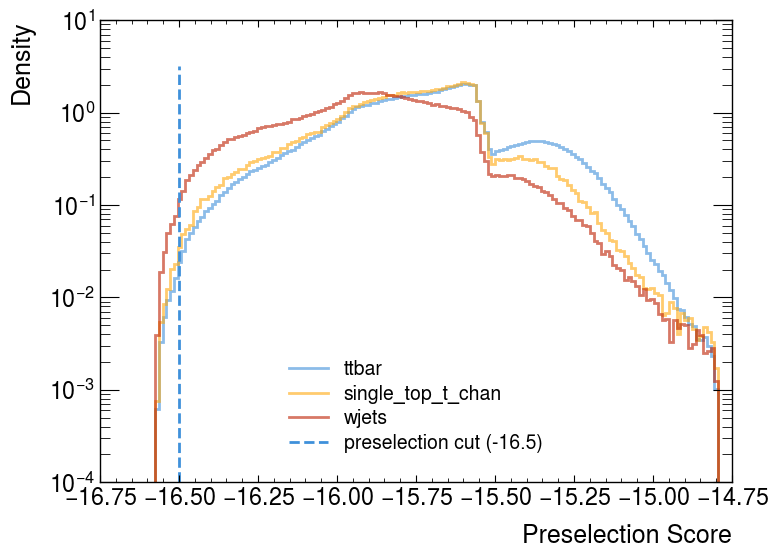

In [10]:
preselection_cut = -16.5 # Lets start with a very loose cut

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut, ymax=0.9, linestyle='--', label=f'preselection cut ({preselection_cut})')
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [11]:
# Make the preselections

training_features = training_features[preselection_score>=preselection_cut].copy()
train_labels = train_labels[preselection_score>=preselection_cut].copy()
weights = weights[preselection_score>=preselection_cut].copy()

preselection_score_selected = preselection_score[preselection_score>=preselection_cut].copy()


In [13]:
# Build a pandas dataframe from the arrays for density ratio training and validation
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
dataset = pd.DataFrame(training_features, columns=columns)
dataset['presel_score'] = preselection_score_selected
dataset['weights'] = weights